In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
from calendar import month_name , month_abbr
import multiprocessing
import nltk
from nltk import sentiment
import matplotlib.pyplot as plt
from nltk.corpus import words
from nltk.corpus import wordnet as wn
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
#for filename in os.listdir(os.getcwd()):
   # do your stuff

In [2]:
#os.path.isdir(dirList[10])
working_dir ="/root/home/anaconda2/bin/Python-Learning/RP/anomaly/Junk"
file_list = []
dir_list = []
for root, dirs, files in os.walk(working_dir):
    for filename in files:
        if filename== "secure":
            file_list.append(os.path.join(root, filename)) 
            dir_list.append(root)
    review_file = [open(file,'r').read() for file in file_list]


In [3]:
temp=[[t.replace('/root/home/anaconda2/bin/Python-Learning/RP/anomaly/Junk/','') for t in dir_list]]
#temp

In [4]:
newDF = pd.DataFrame(columns=['folder','content'])
finalDF= pd.DataFrame(columns=['folder','content'])

In [5]:
#Created a dataframe from input values by adding the content and folder name
for i in range(len(review_file)):
    newDF = pd.DataFrame(columns=['folder','content'])
    tempdf = pd.Series( (v for v in review_file[i].splitlines()))
    newDF['content']=tempdf
    newDF['folder']=temp[0][i]
    if newDF.shape[0] !=0:
        finalDF=finalDF.append(newDF,ignore_index=True)
print finalDF.shape

(807336, 2)


In [6]:
#finalDF.to_csv("tempdummy.csv")
finalDF.head()

,folder,content
0,abc-he-orclgg03.pl.lab.uprising.t-mobile.com,Apr 15 03:40:09 abc-he-orclgg03 sshd[12653]: A...
1,abc-he-orclgg03.pl.lab.uprising.t-mobile.com,Apr 15 03:40:10 abc-he-orclgg03 sshd[12653]: p...
2,abc-he-orclgg03.pl.lab.uprising.t-mobile.com,Apr 15 03:40:10 abc-he-orclgg03 sshd[12663]: p...
3,abc-he-orclgg03.pl.lab.uprising.t-mobile.com,Apr 15 03:40:10 abc-he-orclgg03 sshd[12659]: p...
4,abc-he-orclgg03.pl.lab.uprising.t-mobile.com,Apr 15 03:40:11 abc-he-orclgg03 sshd[12663]: p...


In [7]:
mnth_search='|'.join(month_abbr[1:])

Functions Used For Extraction

In [8]:
def month(x,mnth_search):
    # let's create a function that squares every value in the dataframe
        m=re.match(mnth_search, x)
        value=0
        if m:
            value=m.group()
        return value

#myregex="("+mnth_search + ")\s+(\d+)\s+(\d+:\d+:\d+)\s+([^\s]+)\s(\w+)"

myregex="("+mnth_search + ")\s+(\d+)\s+(\d+:\d+:\d+)\s+([^\s]+)\s(\w+).*"
def month_date_time_foldname_oper(x,myregex):
        m=re.match(myregex,x)
        month=0
        day=0
        time=0
        oper=None
        foldname=None
        #ip=None
        if m:
            month=m.group(1)
            day=m.group(2)
            time=m.group(3)
            foldname=m.group(4)
            oper=[m.group(5) if m.group(5) else None]
            #ip=[m.group(6) if m.group(6) else None]
            
        return (month,day,time,foldname,oper)

#Check if word 'user' occurs and then get the user name
user_reg=".*(?i)user=([a-zA-Z_@]+)|.*(?i)user\s+([a-zA-Z_@()]+)"
def user_check(x,myregex):
    user = None
    m = re.match(myregex,x)
    if m:
        user= m.group(1) if m.group(1)!=None else m.group(2)
    return user

#Check existence of slef-defined critical words 
def critical_words(x):
    match=re.findall(r"(?i)\binvalid\b|\berror\b|\bfailure\b|\bfailed\b|\bunregistered\b|\bwarn\b", x)
    return match

In [9]:
#Add Month Day and Time
finalDF['Mon_Day_Time']=finalDF['content'].apply(lambda x: month_date_time_foldname_oper(x,myregex))


Adding the extracted data as separate column in dataframe

In [10]:
#Unpacking the tuple
new_col_list = ['Month','Date','Time','FoldName','Oper']
for n,col in enumerate(new_col_list):
    finalDF[col] = finalDF['Mon_Day_Time'].apply(lambda x: x[n])
#finalDF = finalDF.drop('Mon_Day_Time',axis=1)

In [11]:
#Add username as additional column
finalDF['User']=finalDF['content'].apply(lambda x: user_check(x,user_reg))

#Add Critical WOrds identified in each row as separate column
finalDF['Critical_Words']=finalDF['content'].apply(lambda x: critical_words(x))

Break critical words into different columns

In [12]:
#Break critical words into different columns
def critical_words_unpack(temp):
    failure=failed=error=invalid=warn=unregistered=None
    if len(temp)!=0:
        for a,x in enumerate(temp):
            if x=='failure':
                failure=True
            elif x=='failed':
                failed=True
            elif x=='error':
                error=True
            elif x=='invalid':
                invalid=True
            elif x=='warn':
                warn=True
            elif x=='unregistered':
                unregistered=True
    return (failure, failed,error,invalid,warn,unregistered)

In [13]:
temp=finalDF['Critical_Words'].apply(lambda x: critical_words_unpack(x))
#Unpacking the tuple for critical words
new_col_list = ['failure','failed','error','invalid','warn','unregistered']
for n,col in enumerate(new_col_list):
    finalDF[col] = temp.apply(lambda x: x[n])

In [15]:
finalDF[finalDF['Critical_Words'].str.len()!=0]['User'].value_counts()


svc_slr_scpt@lab    43240
errobi                 71
mapr                    5
(mapr)                  3
Name: User, dtype: int64

Also check manually for few specific errors

In [16]:
#Category of Occurence of some anomaly like
#Password check fail
#authentication failure

def password_check(x):
    return bool(re.search('(?i)password check',x))

def authentication_failure(x):
    return bool(re.search('(?i)authentication (fail)',x))

def failed_password(x):
    return bool(re.search('(?i)(fail.*? password)',x))
    

In [20]:
finalDF['Password_check']=finalDF['content'].apply(lambda x: password_check(x))
finalDF['Authentication_failure']=finalDF['content'].apply(lambda x: authentication_failure(x))
finalDF['Failed_password']=finalDF['content'].apply(lambda x: failed_password(x))


In [18]:
#finalDF.head()

## Types of Failures in system

In [21]:
#Types of Failures in system
finalDF.select_dtypes(include=['bool']).sum()

Password_check                3
Authentication_failure    43316
Failed_password               3
dtype: int64

In [22]:
#Convert None to False 
finalDF[["failure","failed","error","invalid","warn","unregistered"]]=finalDF[["failure","failed","error","invalid","warn","unregistered"]].applymap(lambda x: False if x is None else True)


## Occurence of Words we searched manually 

In [23]:
#Types of Failures in system
finalDF.select_dtypes(include=['bool']).sum()

failure                   43316
failed                       13
error                        10
invalid                   92532
warn                          0
unregistered                  0
Password_check                3
Authentication_failure    43316
Failed_password               3
dtype: int64

Keeping Only String in each row for further analysis

In [25]:
#Cleanup data for textual analysis
#Remove Month	Date	Time	FoldName	Oper	User from the data of each line
#Then keep only character values and spaces as an alternative
newregex="("+mnth_search + ")\s+\d+\s+\d+:\d+:\d+\s+[^\s]+\s\w+\W+\d+\]:"
def keep_only_string(x):
    only_string= re.sub(newregex,'', x)
    only_string= re.sub('[^a-zA-Z //]',' ', only_string)
    only_string=re.sub('\s+',' ', only_string)
    return only_string


In [26]:
finalDF['StringOnly']= finalDF['content'].apply(lambda x: keep_only_string(x))

In [28]:
y="'Apr 15 03:40:10 sdsdssdfsfs: fsfsfffrrr): session opened for user sdsds by (uid=1111)'"
temp=re.sub(newregex,'', y)
temp=re.sub('[^a-zA-Z //]',' ', temp)
re.sub('\s+',' ', temp)

' Apr sdsdssdfsfs fsfsfffrrr session opened for user sdsds by uid '

In [29]:
#Removeing stopwords
stopwords=nltk.corpus.stopwords.words("english")

' pam unix sshd auth authentication failure logname uid euid tty ssh ruser rhost user svc slr scpt lab'

# Sentiment Analysis Based Findings

In [30]:
sent_neg_score=sentiment.SentimentIntensityAnalyzer()
finalDF['NegScore']= finalDF['StringOnly'].apply(lambda x: sent_neg_score.polarity_scores(x)['neg'])

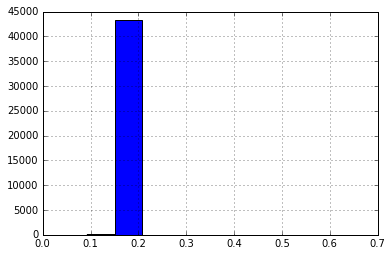

In [31]:
finalDF[finalDF.NegScore>0]['NegScore'].hist()
plt.show()

Scores Identified and their count

In [32]:
#Do word cloud???
finalDF['NegScore'].value_counts()

0.000    764004
0.163     43240
0.180        52
0.093        18
0.667        10
0.191         5
0.398         3
0.355         3
0.096         1
Name: NegScore, dtype: int64

In [449]:
finalDF[finalDF['NegScore']>0]['content'][2]

'Apr 15 03:40:10 abc-he-orclgg03 sshd[12663]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=10.253.228.58  user=svc_slr_scpt@lab'

Words and Their Count in the dataframe

In [162]:
finalDF.select_dtypes(include=['bool']).sum()

failure                   43316
failed                       13
error                        10
invalid                   92532
warn                          0
unregistered                  0
Password_check                3
Authentication_failure    43316
Failed_password               3
dtype: int64

In [212]:
import time
finalDF['Hour']=finalDF['Time'].apply(lambda x: time.strptime(x,"%H:%M:%S").tm_hour)

How Does the data look Grouped by Critical words and Score.

We see Invalid not beng given a negative score

In [255]:
#finalDF.groupby(['Critical_Words','NegScore']).agg('count')
temp=finalDF.copy()
temp['Critical_Words'] = temp['Critical_Words'].apply(tuple)
pd.DataFrame(temp.groupby(['Critical_Words','NegScore'])['folder'].agg('count').reset_index())

#temp.head()

,Critical_Words,NegScore,folder
0,(),0.000,671472
1,"(Failed,)",0.355,3
2,"(error, failed)",0.667,10
3,"(failed,)",0.398,3
4,"(failure,)",0.093,18
5,"(failure,)",0.096,1
6,"(failure,)",0.163,43240
7,"(failure,)",0.180,52
8,"(failure,)",0.191,5
9,"(invalid,)",0.000,92532


In [217]:
#temp[temp['NegScore']==0.191]
finalDF['FoundNegScore'] = finalDF['NegScore'].apply(lambda x: 1 if x > 0 else 0)

## Incident Occurences Over Time 

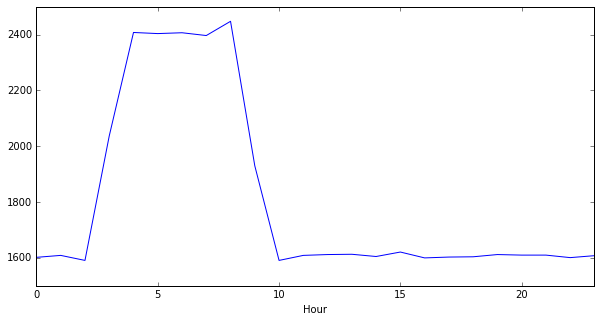

Hour
0     1602
1     1609
2     1591
3     2037
4     2408
5     2404
6     2407
7     2397
8     2448
9     1930
10    1591
11    1609
12    1612
13    1613
14    1605
15    1621
16    1600
17    1603
18    1604
19    1612
20    1610
21    1610
22    1601
23    1608
Name: FoundNegScore, dtype: int64


In [540]:
#Occurence of failure incidents by time (as invalid is  not capyured as negative score for now)

finalDF.groupby('Hour')['FoundNegScore'].sum().plot(figsize = (10,5))
plt.show()
print finalDF.groupby('Hour')['FoundNegScore'].sum()

## Count of a negative sentiment by User

User
svc_slr_scpt@lab    43240
errobi                 71
mapr                    5
(mapr)                  3
uemm                    0
solarmntr               0
root                    0
oracle                  0
not                     0
hawkeye                 0
femm                    0
edghhjf                 0
Name: FoundNegScore, dtype: int64


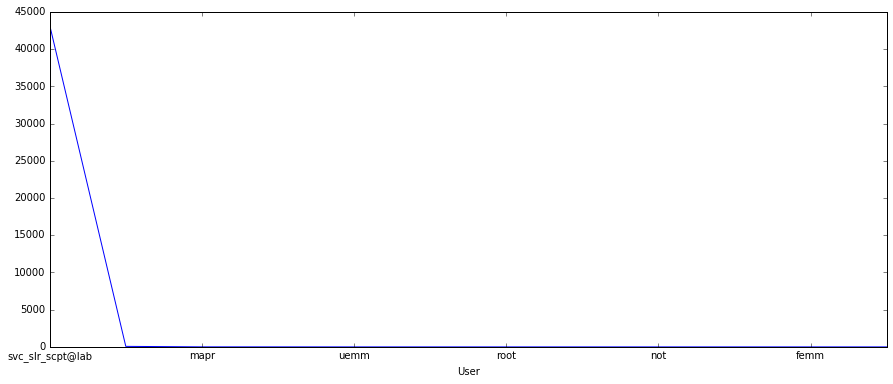

In [253]:
#Negative Score by User
print finalDF.groupby('User')['FoundNegScore'].sum().sort_values(ascending=False)
finalDF.groupby('User')['FoundNegScore'].sum().sort_values(ascending=False).plot(figsize=(15,6))
plt.show()


In [260]:
finalDF[['folder','Mon_Day_Time','content','StringOnly']].to_csv("tempdummy.csv")

In [271]:
from nltk.corpus import words as english
#nltk.download()
nltk.download('words')
nltk.download('stopwords')

In [346]:
#wordnet.words().__contains__("failed")
#wn.synset('fails')
#wn.lemma('fails')
#acknowledgment_synset
k=[w for w in wn.words()]
syn = wn.synsets('warnings')[0]
lemmas = syn.lemmas()
lemmas[0].name()

wn.synsets('warnings')[0].lemmas()[0].name()

u'warning'

In [369]:
wordnet_words=[w for w in wn.words()]

In [372]:
vocab = set(w.lower() for w in english.words())
manywords = words.words() + wordnet_words
stp_wrds=set(w.lower() for w in stopwords)

In [378]:
sentence="Arthur fails didn't failed  123 feel a very warn warn good"
tokens = nltk.word_tokenize(sentence)
k=[item for item in tokens if item not in stp_wrds]
print k
v=[item for item in k if item in manywords]
print v
#' '.join(v)


['Arthur', 'fails', "n't", 'failed', '123', 'feel', 'warn', 'warn', 'good']
['Arthur', 'feel', 'warn', 'warn', 'good']


In [436]:
#stemmer = SnowballStemmer("english")

lemmatizer = WordNetLemmatizer()

def stpwrds_lemma(sent):
    tokens = nltk.word_tokenize(sent)
    cleandata=[item for item in tokens if item not in stp_wrds]
    #print cleandata
    lemmatokens= [ lemmatizer.lemmatize(item) for item in cleandata]
    #print lemmatokens
    #Removing as vocab des not contians words like "accepted", "failed"
    #vocabdata=[item for item in stemtokens if item in vocab]
    #print vocabdata
    #temp=' '.join(vocabdata)
    temp=' '.join(lemmatokens)
    return temp
    

In [424]:
print(lemmatizer.lemmatize("Accpeted"))

Accpeted


In [465]:
finalDF.columns

Index([u'folder', u'content', u'Mon_Day_Time', u'Month', u'Date', u'Time',
       u'FoldName', u'Oper', u'User', u'Critical_Words', u'failure', u'failed',
       u'error', u'invalid', u'warn', u'unregistered', u'Password_check',
       u'Authentication_failure', u'Failed_password', u'StringOnly',
       u'NegScore', u'Hour', u'FoundNegScore', u'StringOnly_Lemma_StpWord'],
      dtype='object')

In [437]:
finalDF['StringOnly_Lemma_StpWord']=finalDF['StringOnly'].apply(lambda x: stpwrds_lemma(x))

In [539]:
# Find sentrnces with 0 , medium and high negative scores
pd.set_option('display.expand_frame_repr', False)
#finalDF[finalDF['NegScore']==0]['content'][10099]
temp=finalDF[finalDF['NegScore']>0.35][['content','NegScore']].reset_index()
temp#['content'][3232]

,index,content,NegScore
0,102351,Apr 16 15:32:43 abc-he-hunk unix_chkpwd[62170]...,0.398
1,102355,Apr 16 15:32:45 abc-he-hunk sshd[62144]: Faile...,0.355
2,102356,Apr 16 15:32:50 abc-he-hunk unix_chkpwd[62196]...,0.398
3,102359,Apr 16 15:32:53 abc-he-hunk sshd[62144]: Faile...,0.355
4,105002,Apr 16 20:37:31 abc-he-hunk sshd[19924]: error...,0.667
5,105003,Apr 16 20:37:31 abc-he-hunk sshd[19924]: error...,0.667
6,105004,Apr 16 20:37:31 abc-he-hunk sshd[19924]: error...,0.667
7,105005,Apr 16 20:37:31 abc-he-hunk sshd[19924]: error...,0.667
8,105006,Apr 16 20:37:31 abc-he-hunk sshd[19924]: error...,0.667
9,105007,Apr 16 20:37:32 abc-he-hunk sshd[19924]: error...,0.667
